In [ ]:
# 指定CPU跑
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# 只输出最后一个表达式
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr' # 'all'

In [1]:
import numpy as np
np.__version__

'1.16.5'

In [2]:
import tensorflow as tf
import numpy as np
tf.__version__

'2.0.0'

# 使用TensorFlow通过回归验证通用近似定理
***
神经网络中，我们把神经元看作网络节点，在节点处通常是使用一个非线性函数$\sigma()$去作用到输入信号上面。~~而在不同层之间的神经元之间会相互连接.~~ 而第n层神经元与第n+1层神经元连接（单向），而这种连接在神经网络中以权重w进行表示。  
那么**信号由第n层到第n+1层中的第i个神经元**，便可以表示成如下(其中m表示此批次的样本数)：
$$
x_i^{(n+1)} = \sigma(\sum_m{w^{(n)}_m x^{(n)}_m + b^{(n)}})
$$
从上面的公式也可以看出，n+1层的神经元通常会与上一层的每个神经元存在联系（全连接时），而在单层神经元之间彼此通常是没有直接连接的。那么如果我们能证明这一层的神经元之间是相互正交的，那么我们就证明了这一层神经元可以拟合得到任意函数。  
证明：  

pass

## 自定义模型实现：

### 批操作生成函数

对输入数据应保持形状为(m,num_feature)， 这样输入神经网络后便可以以矩阵相乘的形式得到最后为(m, num_class)的结果，即  
(m, num_feature)* (num_feature, hidden1)* (hidden1, hidden2)* ... * (hiddenN, num_classis)

In [3]:
tf.test.is_gpu_available()

True

In [4]:
# 批操作
x_data = np.linspace(0,10,100)

def genData(x_data,batch_size=100):
    L = len(x_data)
    idx = np.arange(0,L)
    count=0
    while True: # 让其一轮结束后开始新一轮
#         count += 1
        np.random.shuffle(idx)
        batchs = L//batch_size
        for i in range(batchs):
#             print(count)
            x = x_data[idx][i*batch_size:(i+1)*batch_size].reshape(batch_size,-1)
            yield x,tf.constant(np.sin(x))

In [5]:
g = genData(x_data)

In [6]:
X,Y = next(g) 
X.shape,Y.shape

((100, 1), TensorShape([100, 1]))

In [7]:
# Y = np.square(X)

print(Y.shape)
print(X.shape)

(100, 1)
(100, 1)


In [8]:
X.shape

(100, 1)

In [9]:
# tf.Variable(np.random.randn(50,3))@tf.Variable(np.random.randn(3,3))+ tf.Variable(np.random.randn(50,3))
a = np.random.randn(5,3,3)
print('第0，1维度\n',a[:,:,1]) # 返回 5*3
print('第1，2维度\n',a[1,:,:]) # 返回3*3
print('第0，2维度\n',a[:,1,:]) # 5*3

第0，1维度
 [[-0.07803436  0.07443043  0.01425555]
 [ 0.07835099 -0.89641076  0.92866728]
 [-2.18200228 -0.32295469 -0.27079246]
 [ 1.97772296  0.53599538  0.30281561]
 [ 0.30450185  0.20501183  0.01792392]]
第1，2维度
 [[ 0.02818004  0.07835099 -2.82229452]
 [ 0.97324776 -0.89641076  0.77569904]
 [-0.5281759   0.92866728 -0.95688683]]
第0，2维度
 [[ 0.47332855  0.07443043  0.16956779]
 [ 0.97324776 -0.89641076  0.77569904]
 [-0.96520835 -0.32295469  0.16751181]
 [-0.89925942  0.53599538 -0.87875472]
 [-0.66098827  0.20501183 -1.16437422]]


In [10]:
np.random.randn(5,3)

array([[-2.04263872, -1.40817518, -1.19860151],
       [ 0.46520557,  1.58529264, -0.82381341],
       [-0.89285888, -0.71141718, -1.17559021],
       [ 1.61935889,  1.26471396, -0.70699447],
       [-0.4449273 , -0.54322787, -0.0978487 ]])

In [ ]:
class Model:
    def __init__(self, input_shape=[50,1],num_layers = 2):
        '''input_shape = [batch_size, feature_size]'''
        # 把这里的input_shape　使用类似placeholder的方式先不要确定。在后面model(X)的时候读取Ｘ的shape去得到它的input_shape
        
        self.batch_size, self.num_feature = input_shape[0], input_shape[1]
        self.num_layers = num_layers

        hidden1, hidden2 = 100,100 # 单个隐藏层神经元个数
        out_put = 1
        self.w0 = tf.Variable(np.random.randn(self.num_feature, hidden1), name = 'weight0')
        self.b0 = tf.Variable(np.random.randn(self.batch_size, hidden1), name = 'bias0')
        
        self.w1 = tf.Variable(np.random.randn(hidden1, hidden2, num_layers), name = 'weight1')
        self.b1 = tf.Variable(np.random.randn(self.batch_size, hidden2, num_layers), name = 'bias1')
        
        self.w2 = tf.Variable(np.random.randn(hidden2, out_put), name = 'weight2')
        self.b2 = tf.Variable(np.random.randn(self.batch_size, out_put), name = 'bias2')
        
        self.wp = tf.Variable(np.random.randn(out_put, out_put), name = 'weight_predict')
        self.bp = tf.Variable(np.random.randn(self.batch_size, out_put), name = 'weight_predict')
        


    def __call__(self,X):
        
#         out = tf.nn.sigmoid(X@ self.w0 + self.b0) # 输入层
        out = tf.nn.sigmoid(tf.multiply(X, self.w0)+ self.b0) # 输入层
        for i in range(self.num_layers):
             out = tf.nn.sigmoid(out @ self.w1[:,:,i] + self.b1[:,:,i])# 隐藏层
    
        out = tf.nn.sigmoid(out@self.w2+self.b2)# 输出层的前一层
        out = out @ self.wp + self.bp # 输出层(预测层)
        return out
        
def lossfunc(OUT,Y):
    return tf.reduce_mean(tf.square(OUT-Y)) 

model = Model(input_shape=[100,1], num_layers=2)
pred = model(X)
# print(pred)
loss = lossfunc(pred,Y)
loss

In [12]:
# Stochastic Gradient Descent Optimizer.
learning_rate = 0.001
optimizer = tf.optimizers.Adam(learning_rate)
# optimizer = tf.optimizers.Adadelta(learning_rate)

In [13]:
# Optimization process. 
def run_optimization():
    # 将导数的计算封装在 GradientTape 中
    with tf.GradientTape() as g:
        loss = lossfunc(model(X),Y)
     
    W = [model.w0, model.b0,model.w1, model.b1,model.w2, model.b2, model.wp, model.bp];
    # 计算loss对W和b的导数：
    gradients = g.gradient(loss, Ｗ)
    # 根据梯度更新W,b
    optimizer.apply_gradients(zip(gradients, W))

In [14]:
# Run training for the given number of steps.
training_steps = 1000
display_step=100

writer = tf.summary.create_file_writer("./mylogs")
with writer.as_default(): # 这是为了后面的tf.summary.scalar()
    for step in range(1, training_steps + 1):
        X,Y = next(genData(x_data))

        # Run the optimization to update W and b values.
        run_optimization()

        tf.summary.scalar('loss',loss, step=step)
        writer.flush()
        if step % display_step == 0:
            pred = model(X)
            loss = lossfunc(pred,Y)
            print("step: {}, loss: {}".format(step, loss))


step: 100, loss: 1.2224336674164997
step: 200, loss: 0.9823400510962039
step: 300, loss: 0.7623542192920982
step: 400, loss: 0.7232742669449911
step: 500, loss: 0.6004289017918907
step: 600, loss: 0.5423235727218432
step: 700, loss: 0.5224155945160492
step: 800, loss: 0.5061058203966233
step: 900, loss: 0.3683496503943392
step: 1000, loss: 0.4484694476201809


tensorboard --logdir=C:\Users\beidongjiedeguang\OneDrive\a_github\tensorflow从0开始\mylogs  
tensorboard --logdir=mylogs    
赋值上面命令到命令行  

http://localhost:6006/#scalars

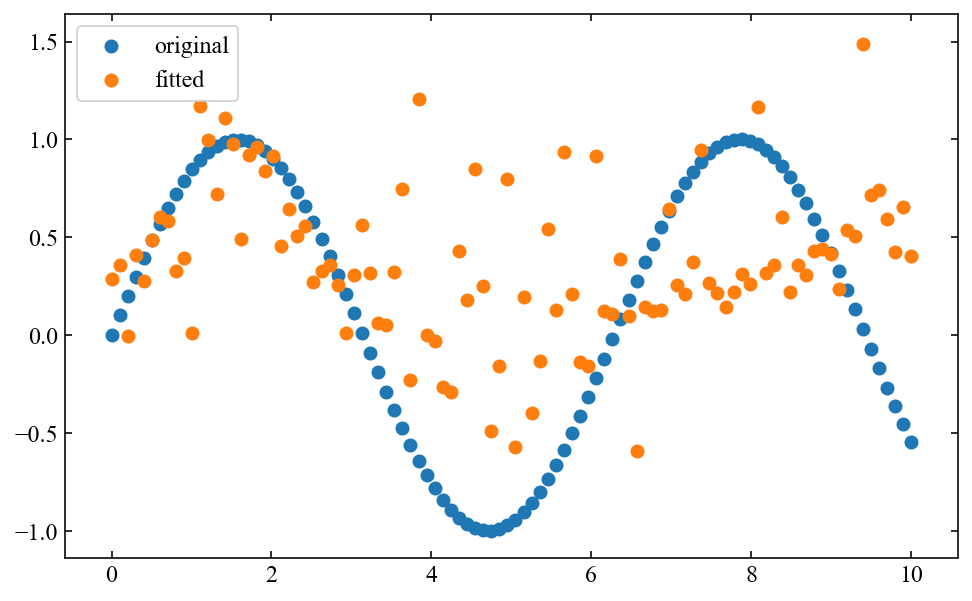

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,5))
plt.scatter(X, Y,label='original')
plt.scatter(X, model(X),label='fitted')
plt.legend()

plt.show()

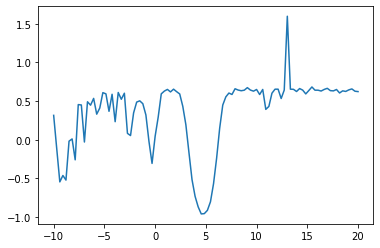

In [26]:
test_x = np.linspace(-10,20,100).reshape(-1,1) # 训练集范围如上图，是从0~10
plt.plot(test_x,model(test_x))
plt.show()

可以看到，在0~10的范围内拟合得十分不错，并且超过10的一定范围内的预测也基本是正确的。

## 使用tf.keras API实现

In [5]:
import tensorflow as tf
import numpy as np
# tf.test.is_gpu_available()
from tensorflow.keras import Input,Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten,Dense,Dropout,Conv2D

In [6]:
def GenerateData(datasize = 200 ):
    train_X = np.linspace(0, 10, datasize)   #train_X为-1到1之间连续的100个浮点数
    train_Y = np.sin(train_X)
    yield train_X, train_Y   #以生成器的方式返回

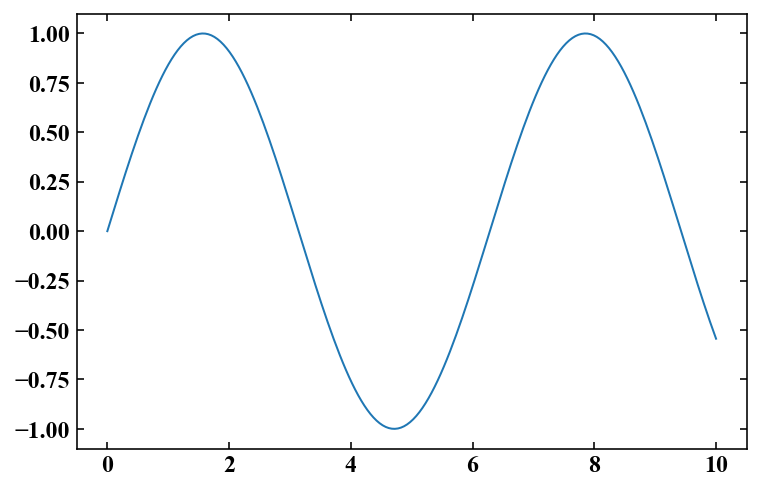

In [7]:
train_data = next(GenerateData())
plt.plot(train_data[0],train_data[1]);

In [8]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = Dense(100, activation='sigmoid', input_shape=(1,)) # 默认use_bias=True
        self.fc2 = Dense(100, activation='sigmoid')
        self.out = Dense(1)
    
    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        return x


my_model = MyModel()  
my_model0 = MyModel()

my_model(train_data[0].reshape(-1,1)).shape
my_model0(train_data[0].reshape(-1,1)).shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



InternalError: Blas GEMM launch failed : a.shape=(200, 1), b.shape=(1, 100), m=200, n=100, k=1 [Op:MatMul]

**对上述Model使用tf.keras.models.Sequential()实现：**

In [21]:
# 使用Sequential的第一种方式
Net1 = tf.keras.models.Sequential()
Net1.add(Dense(100,activation='sigmoid', input_shape=(1,)))
Net1.add(Dense(100,activation='sigmoid'))
Net1.add(Dense(1))

In [22]:
# 使用Sequential的第2种方式
Net2 = tf.keras.models.Sequential([
    Dense(100,activation='sigmoid', input_shape=(1,)),
    Dense(100,activation='sigmoid'),
    Dense(1)
])

In [23]:
my_model.summary()
Net1.summary()
Net2.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  200       
_________________________________________________________________
dense_1 (Dense)              multiple                  10100     
_________________________________________________________________
dense_2 (Dense)              multiple                  101       
Total params: 10,401
Trainable params: 10,401
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               200       
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
__________________________________

In [24]:
my_model.weights[0].shape # w1
my_model.weights[1].shape # b1
my_model.weights[2].shape # w2
my_model.weights[3].shape # b2
Net1.weights[4].shape # w3
Net2.weights[5].shape # b3

TensorShape([1])

In [25]:
# Model.compile()实现反向传播
my_model.compile(loss='mse', optimizer='Adam')
Net1.compile(loss='mse', optimizer='Adam')

### 可使用两种方式训练模型：

In [ ]:
# 使用集成度较低的 Model.train_on_batch方法，自行设定batch数据　和　ｅpochs
for step in range(2001):
    train_data = next(GenerateData())
    cost = my_model.train_on_batch(train_data[0].reshape(-1,1), train_data[1].reshape(-1,1))
    if step%100==0:
        print(f'loss: {cost}')

loss: 0.8452340960502625
loss: 0.4336927533149719
loss: 0.4149059057235718
loss: 0.37498894333839417
loss: 0.3399243652820587
loss: 0.32301878929138184
loss: 0.3113902807235718
loss: 0.29476645588874817
loss: 0.24649733304977417
loss: 0.18901079893112183
loss: 0.15638774633407593
loss: 0.13984596729278564
loss: 0.12670093774795532
loss: 0.11463484168052673
loss: 0.10299048572778702
loss: 0.09072984755039215
loss: 0.07635632157325745
loss: 0.05919331684708595


In [28]:
# 使用集成度较高的fit()方法，直接指定batch_size, epochs等参数
my_model.fit(x = train_data[0].reshape(-1,1), y=train_data[1].reshape(-1,1), batch_size=100, epochs=100)
Net1.fit(x = train_data[0].reshape(-1,1), y=train_data[1].reshape(-1,1), batch_size=100, epochs=100)

Train on 200 samples
Epoch 1/100
200/200 [==============================] - 0s 922us/sample - loss: 1.1374e-05
Epoch 2/100
200/200 [==============================] - 0s 25us/sample - loss: 1.1726e-05
Epoch 3/100
200/200 [==============================] - 0s 30us/sample - loss: 1.1113e-05
Epoch 4/100
200/200 [==============================] - 0s 25us/sample - loss: 1.1251e-05
Epoch 5/100
200/200 [==============================] - 0s 30us/sample - loss: 1.1132e-05
Epoch 6/100
200/200 [==============================] - 0s 30us/sample - loss: 1.1557e-05
Epoch 7/100
200/200 [==============================] - 0s 25us/sample - loss: 1.2643e-05
Epoch 8/100
200/200 [==============================] - 0s 25us/sample - loss: 1.1833e-05
Epoch 9/100
200/200 [==============================] - 0s 20us/sample - loss: 2.9397e-05
Epoch 10/100
200/200 [==============================] - 0s 25us/sample - loss: 3.4251e-05
Epoch 11/100
200/200 [==============================] - 0s 30us/sample - loss: 1.4395e-

### 对模型进行测试评估与预测：

In [65]:
train_data = next(GenerateData())
test_x, test_y = train_data[0].reshape(-1,1), train_data[1].reshape(-1,1)

In [66]:
# 使用Model.evaluate()方法进行评估，返回 loss
cost = my_model.evaluate(test_x, test_y)
cost

# 使用Model.predict()方法进行预测,返回预测值
my_model.predict(test_x) # 它等价于　my_model(test_x).numpy()

200/200 [==============================] - 0s 25us/sample - loss: 0.0113


array([[ 3.16994821e-02],
       [ 7.46833341e-02],
       [ 1.17558650e-01],
       [ 1.60265123e-01],
       [ 2.02738334e-01],
       [ 2.44909458e-01],
       [ 2.86705146e-01],
       [ 3.28047635e-01],
       [ 3.68854892e-01],
       [ 4.09041318e-01],
       [ 4.48518445e-01],
       [ 4.87195869e-01],
       [ 5.24982522e-01],
       [ 5.61787762e-01],
       [ 5.97522553e-01],
       [ 6.32100233e-01],
       [ 6.65437422e-01],
       [ 6.97454149e-01],
       [ 7.28073809e-01],
       [ 7.57222686e-01],
       [ 7.84829173e-01],
       [ 8.10822557e-01],
       [ 8.35131948e-01],
       [ 8.57684820e-01],
       [ 8.78405746e-01],
       [ 8.97215252e-01],
       [ 9.14028912e-01],
       [ 9.28756802e-01],
       [ 9.41303404e-01],
       [ 9.51567888e-01],
       [ 9.59445268e-01],
       [ 9.64827898e-01],
       [ 9.67607788e-01],
       [ 9.67679570e-01],
       [ 9.64944116e-01],
       [ 9.59312732e-01],
       [ 9.50711824e-01],
       [ 9.39087849e-01],
       [ 9.2

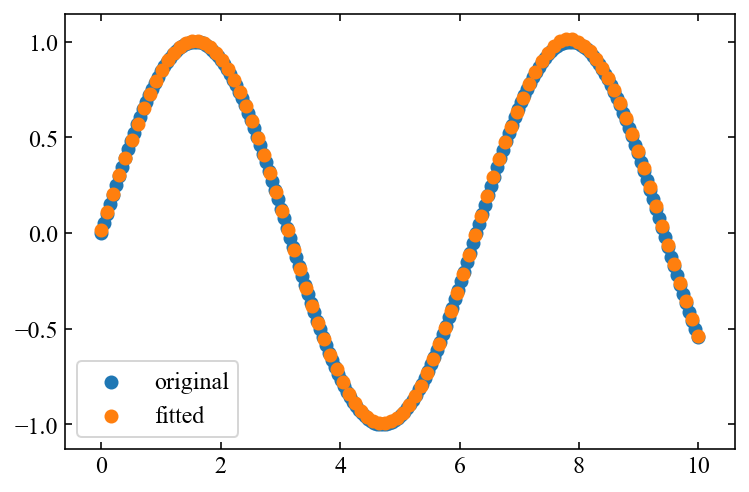

In [29]:
Tx = np.linspace(0,10,100).reshape(100,1)
plt.scatter(train_data[0],train_data[1], label = 'original');

# plt.scatter(Tx,my_model(Tx), label='fitted'); # 与下面等价
plt.scatter(Tx,my_model.predict(Tx), label='fitted');
plt.legend();

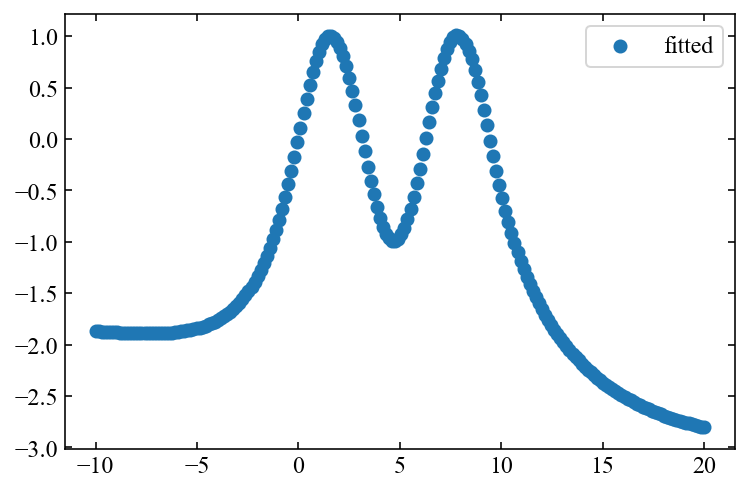

In [30]:
Tx = np.linspace(-10,20,200).reshape(200,1)
plt.scatter(Tx,my_model(Tx), label='fitted');
plt.legend();

In [112]:
# x = tf.keras.Input(shape=(32,10))# 这里shape给出的是input的特征形状，得到的x的shape其实=[batch,shape]
# y = tf.square(x)
# x

### 保存模型与加载模型
* 使用Model.save()方法保存， 通过tf.keras.models.load_model 加载模型
* 使用Model.save_weights()保存， 通过已经定义好的模型使用Model.load_weights()导入，这个已经定义好的模型结构需要与之想匹配，所以可以考虑在初始训练模型之前，做一个模型的备份。


In [113]:
my_model.save_weights('my_model.h5') # my_model只能通过save_weights保存，表示值保存了权重，但模型是没有保存的
Net1.save('Net1.h5') # 而从Sequensial建立的网络可以直接通过save保存，保存的是图+权重

del my_model
del Net1

In [114]:
from tensorflow.keras.models import load_model
# my_model0就是没有训练的MyModel()的一个实例
my_model0 = my_model0.load_weights('my_model.h5') # 保存的权重，必须用一个已经定义了的模型使用Model.load_weights()进行导入
Net1 = load_model('Net1.h5') 